In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
# sns.set(style='ticks', context='paper', font='CMU Sans Serif')
sns.set(style='ticks', context='paper')
from collections import defaultdict
import numpy as np
from util import plot_cdf

Recovered Data: 100


In [32]:
def pn_distance(a, b, p):
    x = a.quantile(p)
    y = b.quantile(p)
    return (y - x) / x
    
def p99_distance(a, b):
    return pn_distance(a, b, 0.99)
NR_PATHS_SAMPLED=1000
n_size_bucket_list_output=4
n_percentiles=20
# P99_PERCENTILE_LIST = np.array(
#     [10, 20, 30, 40, 50, 60, 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
# )
P99_PERCENTILE_LIST = np.array(
    [10, 25, 40, 55, 70, 75, 80, 85, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 99.9, 99.99]
)
MTU=1000
BDP = 15 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}
_fontsize=15
N_FLOW_THRESHOLD = 1

In [3]:
def recover_data(sampling_percentiles, sampled_data,target_percentiles):
    recovered_data = []

    for percentile in target_percentiles:
        # Find the two nearest percentiles in the sampled data
        lower_percentile = max(filter(lambda x: x <= percentile, sampling_percentiles), default=0)
        upper_percentile = min(filter(lambda x: x >= percentile, sampling_percentiles), default=100)

        # Retrieve corresponding values from the sampled data
        lower_index = np.where(sampling_percentiles == lower_percentile)[0][0] if lower_percentile in sampling_percentiles else 0
        upper_index = np.where(sampling_percentiles == upper_percentile)[0][0] if upper_percentile in sampling_percentiles else -1

        lower_value = sampled_data[lower_index]
        upper_value = sampled_data[upper_index]

        # Interpolate to recover the original data
        recovered_value = np.interp(percentile, [lower_percentile, upper_percentile], [lower_value, upper_value])

        # Append the recovered value to the list
        recovered_data.append(recovered_value)

    return recovered_data

# Example sampled data as a list of values and sampling percentiles
sampled_data = np.array([10.0, 20.0, 30.0])
sampling_percentiles = np.array([10, 50, 90])
# Define the target percentiles at 1% intervals
# target_percentiles = np.arange(0.1, 100.1, 0.2)
target_percentiles = np.arange(1, 101, 1)
# Recover the original data
recovered_data = recover_data(sampling_percentiles, sampled_data,target_percentiles)

# Display the recovered data
print("Recovered Data:", len(recovered_data))


Recovered Data: 100


n_freq_list:  984 1003
bucket_ratios:  [0.59824573 0.11229048 0.13980906 0.14965473]
df_mlsys_bucket:  [50.0228053  61.67338534 81.6199068   3.69496532]
sldn_ns3:  5.580558836029968  sldn_pmn_m:  5.685178374883054  df_mlsys:  65.25656434000003
df_ns3: 9999824, df_pmn_m: 10000000, df_mlsys: [100000, 97600, 98100, 98500]


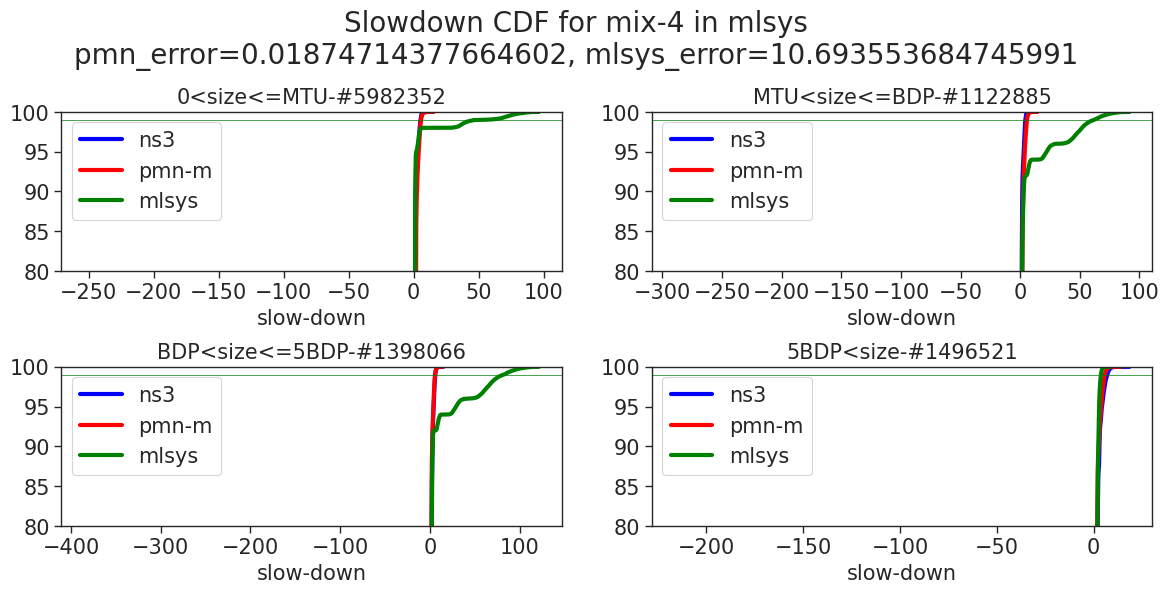

In [33]:
# test mix 4 with aggreagted feat map from mlsys
worst_low_id=4
# mlsys_dir="mlsys_s2_bt100"
mlsys_dir="mlsys"
mix_dir = f'../data/{worst_low_id}'
# Accuracy metrics
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]

n_freq_list=[]
n_flow_list=[]
sizes=df_pmn_m['size']
path_idx=0
while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        lines = file.readlines()
        n_freq_list.append(int(lines[0].strip().split(",")[-1]))
        
        flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
        size_list=[sizes[flowid] for flowid in flowid_list]
        
        tmp=np.digitize(size_list, bin_size_list)
        # Count occurrences of each bin index
        bin_counts = np.zeros(n_size_bucket_list_output)
        for bin_idx in tmp:
            bin_counts[bin_idx]+=1
        n_flow_list.append(bin_counts>N_FLOW_THRESHOLD)
        
    path_idx+=1
print("n_freq_list: ",len(n_freq_list),np.sum(n_freq_list))
with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
    lines = file.readlines()
    lines = lines[1:-1]
    for line_idx,line in enumerate(lines):
        data=line.strip().split(",")
        data = [float(value) for value in data]
        # assert len(data) == 100
        n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
        if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]:
            for _ in range(n_freq):
                df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]

sizes=df_ns3['size']
bin=np.digitize(sizes, bin_size_list)

bin_counts = np.bincount(bin)
total_count = np.sum(bin_counts)
# # Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
print("bucket_ratios: ",bucket_ratios)

df_mlsys_bucket=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
print("df_mlsys_bucket: ",df_mlsys_bucket)
# df_mlsys_p99=np.sum(np.multiply(df_mlsys_p99.T, bucket_ratios).T,axis=0)
df_mlsys_total=[]
for i in range(len(df_mlsys)):
    df_mlsys_total.extend(df_mlsys[i])
df_mlsys_p99=np.percentile(df_mlsys_total,99)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)

print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," df_mlsys: ", df_mlsys_p99)
error=(sldn_pmn_m_p99-sldn_ns3_p99)/sldn_ns3_p99
error_mlsys=(df_mlsys_p99-sldn_ns3_p99)/sldn_ns3_p99

# assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys_shape}")
# assert df_ns3.shape[0]==df_pmn_m.shape[0]

plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for mix-{worst_low_id} in {mlsys_dir}\npmn_error={error}, mlsys_error={error_mlsys}",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3 = np.extract(bin==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin==i, sldn_pmn_m)
    tmp_sldn_mlsys=df_mlsys[i]
        
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_mlsys), (np.arange(len(tmp_sldn_mlsys))/len(tmp_sldn_mlsys)*100), label='mlsys', color='green', linewidth=3)
    # plt.plot(np.sort(tmp_sldn_flowsim), (np.arange(len(tmp_sldn_flowsim))/len(tmp_sldn_flowsim)*100), label='flowsim', color='orange', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()


0: (4, 100000), 9
n_flows_in_f:  50 2000.0 24517
sldn_ns3:  12.745050599792657  sldn_pmn_m:  13.701653961088784  sldn_mlsys:  14.43172085192301
df_mlsys:  [19.22424354, 11.595326949999965, 11.555109034999985, 12.218853]

1: (4, 100000), 9
n_flows_in_f:  50 2000.0 24517
sldn_ns3:  5.0016914824769145  sldn_pmn_m:  4.944400905905341  sldn_mlsys:  5.233132475134535
df_mlsys:  [7.9030576, 4.7061706, 3.7332587, 3.606555156999992]

2: (4, 100000), 10
n_flows_in_f:  50 1971.0 24517
sldn_ns3:  9.988582763779297  sldn_pmn_m:  10.40047235928174  sldn_mlsys:  9.709034428920257
df_mlsys:  [13.696335, 8.262105, 7.441467605999999, 7.5290294]

3: (4, 100000), 4
n_flows_in_f:  50 182.0 2096
sldn_ns3:  9.669452140373783  sldn_pmn_m:  11.555822140759261  sldn_mlsys:  8.380227356490073
df_mlsys:  [9.677167249999986, 7.066508953999995, 9.420285189999985, 10.352065629999995]

4: (4, 100000), 4
n_flows_in_f:  50 183.0 2096
sldn_ns3:  5.580558836029968  sldn_pmn_m:  5.685178374883054  sldn_mlsys:  4.09729895

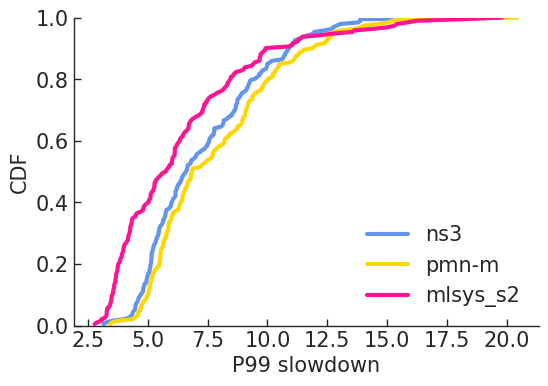

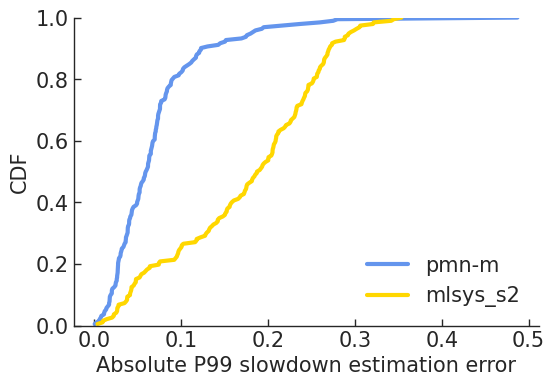

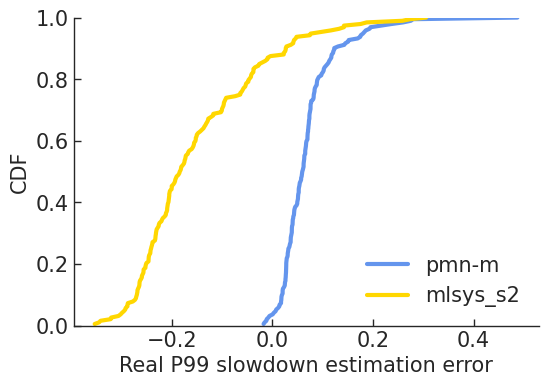

In [7]:
NR_PATHS_SAMPLED=1000
NR_INTEPOLATE=100
# mlsys_dir_list=["mlsys_bt100"]
mlsys_dir_list=["mlsys"]
legend_list=['ns3','pmn-m',"mlsys_s2"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./gen_{mlsys_dir}.npy'
    # legend_list.append(mlsys_dir)
    if not os.path.exists(save_file):
        res_final=[]
        n_flows_median_list=[]
        for worst_low_id in range(0,192):
            res_tmp=[]
            mix_dir = f'../data/{worst_low_id}'
            # Accuracy metrics
            df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
            df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
            df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
            
            sizes=df_pmn_m['size']
            path_idx=0
            # mix_dir = f'/data2/lichenni/data_10m/{worst_low_id}'
            n_freq_list=[]
            n_flows_in_f_list=[]
            n_flow_list=[]
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_freq_list.append(int(data[-1]))
                    n_flows_in_f_list.append(int(data[-3]))
                    
                    flowid_list=[int(tmp) for tmp in lines[2].strip().split(",")]
                    size_list=[sizes[flowid] for flowid in flowid_list]
                    
                    tmp=np.digitize(size_list, bin_size_list)
                    # Count occurrences of each bin index
                    bin_counts = np.zeros(n_size_bucket_list_output)
                    for bin_idx in tmp:
                        bin_counts[bin_idx]+=1
                    n_flow_list.append(bin_counts>N_FLOW_THRESHOLD)
        
                path_idx+=1
            assert sum(n_freq_list)==NR_PATHS_SAMPLED
            with open(f'{mix_dir}/{mlsys_dir}/path.txt', 'r') as file:
                lines = file.readlines()
            lines = lines[1:-1]
            for line_idx,line in enumerate(lines):
                data=line.strip().split(",")
                data = [float(value) for value in data]
                assert len(data) == NR_INTEPOLATE
                n_freq=n_freq_list[line_idx//n_size_bucket_list_output]
                if n_flow_list[line_idx//n_size_bucket_list_output][line_idx%n_size_bucket_list_output]:
                    for _ in range(n_freq):
                        df_mlsys[line_idx%n_size_bucket_list_output].extend(data)
                
            df_mlsys_shape=[len(df_mlsys[i]) for i in range(len(df_mlsys))]
            print(f"\n{worst_low_id}: {df_mlsys_shape}, {np.max(n_freq_list)}")
            print("n_flows_in_f: ",np.min(n_flows_in_f_list),np.median(n_flows_in_f_list),np.max(n_flows_in_f_list))
            n_flows_median_list.append(np.median(n_flows_in_f_list))
            
            sizes_ns3=np.array(df_ns3['size'])
            sizes_pmn=np.array(df_pmn_m['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_pmn=np.digitize(sizes_pmn, bin_size_list)
            
            bin_counts = np.bincount(bin_ns3)
            total_count = np.sum(bin_counts)
            bucket_ratios = bin_counts / total_count
            sldn_mlsys_p99=np.array([np.percentile(df_mlsys[i],99) for i in range(len(df_mlsys))])
            print("bucket_ratios: ",bucket_ratios)
            print("df_mlsys_p99: ",sldn_mlsys_p99)
            sldn_mlsys_p99=np.sum(np.multiply(sldn_mlsys_p99.T, bucket_ratios).T,axis=0)

            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)
                
            print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,sldn_mlsys_p99])

            # assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
            # print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys.shape[1]}")
            
            tmp_data=[]
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_pmn_m = np.extract(bin_pmn==i, sldn_pmn_m)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                sldn_pmn_m_p99=np.percentile(tmp_sldn_pmn_m,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,df_mlsys_p99])
                tmp_data.append(df_mlsys_p99)
            print("df_mlsys: ",tmp_data)
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        np.save(save_file,res_final)
    else:
        res_final=np.load(save_file)
    if mlsys_dir_idx==0:
        res.append(res_final[:,0,0].transpose())
        res.append(res_final[:,0,1].transpose())
        res.append(res_final[:,0,2].transpose())
    else:
        res.append(res_final[:,0,-1].transpose())

res=np.array(res)
print(res.shape)
n_flows_median_list=np.array(n_flows_median_list)
print("n_flows_median_list: ",n_flows_median_list)

plot_cdf(res,'xxx.pdf',legend_list,'P99 slowdown',legend_font=15,group_size=len(res),loc=4,rotate_xaxis=False)

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_cdf(error_abs,'xxx.pdf',[legend_list[i] for i in range(1,len(legend_list))],'Absolute P99 slowdown estimation error',legend_font=15,group_size=len(error_abs),loc=4,rotate_xaxis=False)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_cdf(error_real,'xxx.pdf',[legend_list[i] for i in range(1,len(legend_list))],'Real P99 slowdown estimation error',legend_font=15,group_size=len(error_real),loc=4,rotate_xaxis=False) 

(2, 192)
(192,)
(2, 192)


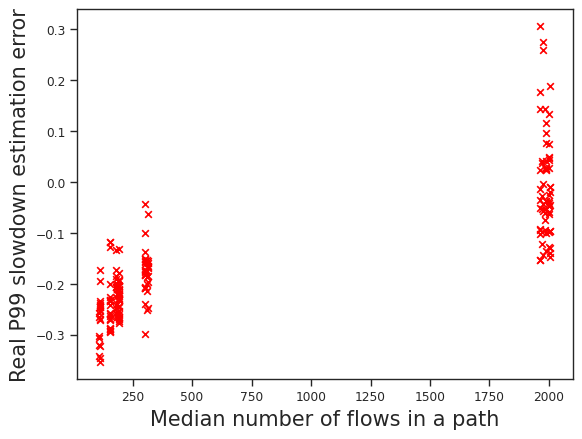

In [13]:
_fontsize=15
error_real=np.array(error_real)
print(error_real.shape)
print(n_flows_median_list.shape)
new_data=np.array([error_real[1],n_flows_median_list])
print(new_data.shape)
plt.scatter(n_flows_median_list,error_real[1],marker='x',color='red')
plt.xlabel('Median number of flows in a path', fontsize=_fontsize)
plt.ylabel('Real P99 slowdown estimation error', fontsize=_fontsize)
plt.show()

(3, 192, 4)


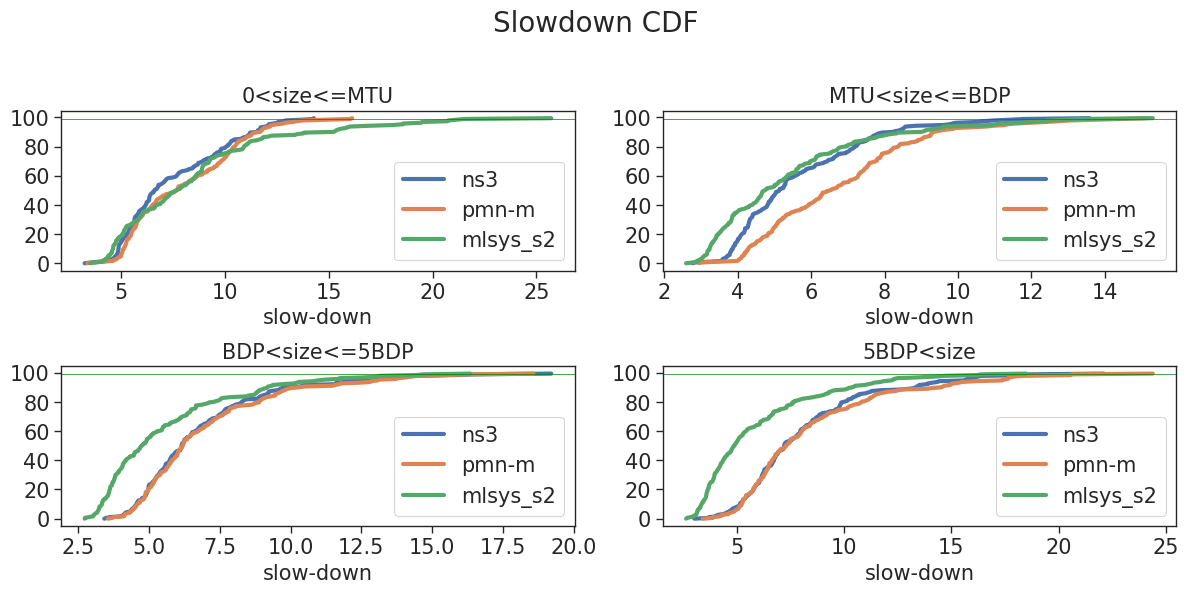

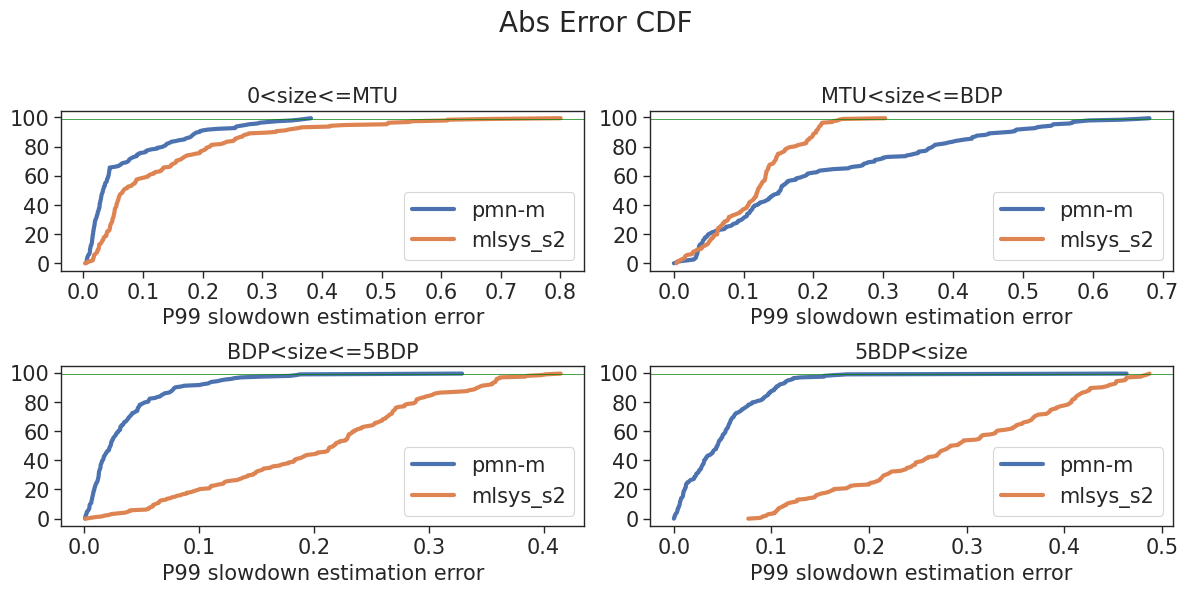

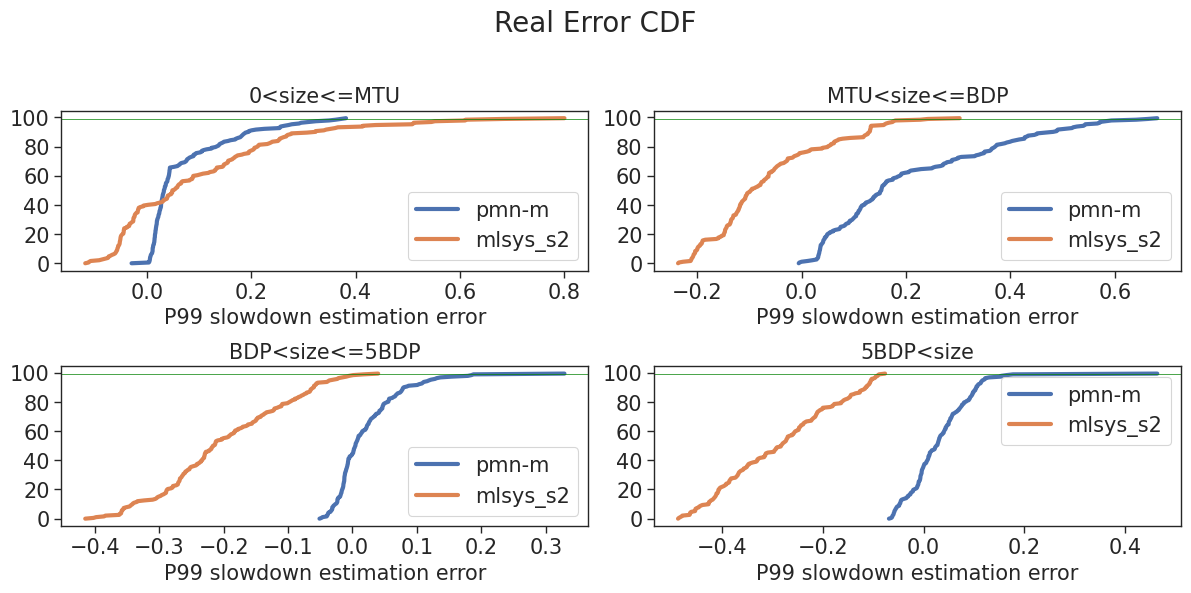

In [29]:
# save_file=f'./data_10m/gen_mlsys.npy'
# mlsys_dir_list=["mlsys_bt100"]
mlsys_dir_list=["mlsys"]
legend_list=['ns3','pmn-m',"mlsys_s2"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./gen_{mlsys_dir}.npy'
    # legend_list.append(mlsys_dir)
    if not os.path.exists(save_file):
        res_final=[]
        for worst_low_id in range(0,192):
        # for worst_low_id in range(0,40):
            res_tmp=[]
            mix_dir = f'../data/{worst_low_id}'
            # Accuracy metrics
            df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
            df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
            df_mlsys = []
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt'):
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    n_freq=int(file.readline().strip().split(",")[-1])
                with open(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt', 'r') as file:
                    data = np.array([float(value) for line in file for value in line.split()])
                    assert data.shape[0] == n_size_bucket_list_output*n_percentiles
                    for _ in range(n_freq):
                        tmp_list=[]
                        tmp=data.reshape(n_size_bucket_list_output, n_percentiles)
                        for i in range(n_size_bucket_list_output):
                            tmp_list.append(recover_data(P99_PERCENTILE_LIST, tmp[i].tolist(),target_percentiles))
                        df_mlsys.append(np.array(tmp_list))
                path_idx+=1
            df_mlsys_tmp=np.array(df_mlsys)
            df_mlsys=[]
            for i in range(n_size_bucket_list_output):
                df_mlsys.append(df_mlsys_tmp[:,i,:].flatten())
            df_mlsys=np.array(df_mlsys)

            sizes_ns3=np.array(df_ns3['size'])
            sizes_pmn=np.array(df_pmn_m['size'])
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_pmn=np.digitize(sizes_pmn, bin_size_list)
            
            # Count occurrences of each bin index
            bin_counts = np.bincount(bin_ns3)
            # Calculate the total count
            total_count = np.sum(bin_counts)
            # Calculate the ratio for each bucket
            bucket_ratios = bin_counts / total_count
            sldn_mlsys=np.sum(np.multiply(df_mlsys.T, bucket_ratios).T,axis=0)

            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            # print(f"{worst_low_id}: path={src_dst_pair}, len=",df_ns3.shape[0],df_pmn_m.shape[0],df_ns3_path.shape[0],df_flowsim.shape[0])
            sldn_ns3_p99=np.percentile(sldn_ns3,99)
            sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)
            sldn_mlsys_p99=np.percentile(sldn_mlsys,99)
                
            print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," sldn_mlsys: ", sldn_mlsys_p99)

            res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,sldn_mlsys_p99])

            # assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
            print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys.shape[1]}")
            
            bin_ns3=np.digitize(sizes_ns3, bin_size_list)
            bin_pmn=np.digitize(sizes_pmn, bin_size_list)
            for i in range(len(bin_size_list)+1):
                tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
                tmp_sldn_pmn_m = np.extract(bin_pmn==i, sldn_pmn_m)
                tmp_sldn_mlsys=df_mlsys[i]
                
                sldn_ns3_p99=np.percentile(tmp_sldn_ns3,99)
                sldn_pmn_m_p99=np.percentile(tmp_sldn_pmn_m,99)
                df_mlsys_p99=np.percentile(tmp_sldn_mlsys,99)
                res_tmp.append([sldn_ns3_p99,sldn_pmn_m_p99,df_mlsys_p99])
            res_final.append(res_tmp)
        res_final = np.array(res_final)
        np.save(save_file,res_final)
    else:
        res_final=np.load(save_file)
    if mlsys_dir_idx==0:
        res.append(res_final[:,1:,0])
        res.append(res_final[:,1:,1])
        res.append(res_final[:,1:,2])
    else:
        res.append(res_final[:,1:,-1])

res=np.array(res)
print(res.shape)

plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF\n",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}",fontsize=_fontsize)
    for j in range(len(legend_list)):
        tmp = res[j,:,i]
        plt.plot(np.sort(tmp), (np.arange(len(tmp))/len(tmp)*100), label=legend_list[j], linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    # plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

plt.figure(1,figsize=(12, 6))
plt.suptitle(f"Abs Error CDF\n",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}",fontsize=_fontsize)
    for j in range(1,len(legend_list)):
        tmp = np.abs(res[j,:,i]-res[0,:,i])/res[0,:,i]
        plt.plot(np.sort(tmp), (np.arange(len(tmp))/len(tmp)*100), label=legend_list[j], linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    # plt.ylim(80, 100)
    plt.xlabel('P99 slowdown estimation error', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

plt.figure(2,figsize=(12, 6))
plt.suptitle(f"Real Error CDF\n",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}",fontsize=_fontsize)
    for j in range(1,len(legend_list)):
        tmp = (res[j,:,i]-res[0,:,i])/res[0,:,i]
        plt.plot(np.sort(tmp), (np.arange(len(tmp))/len(tmp)*100), label=legend_list[j], linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    # plt.ylim(80, 100)
    plt.xlabel('P99 slowdown estimation error', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

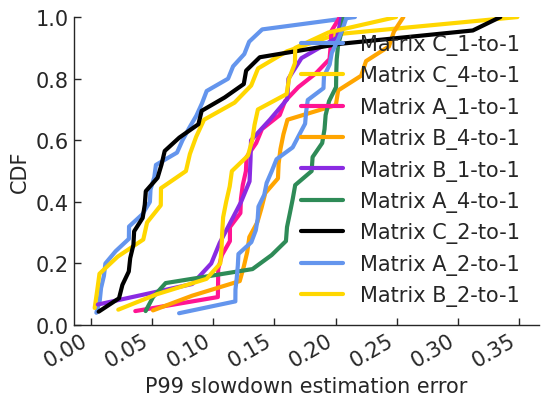

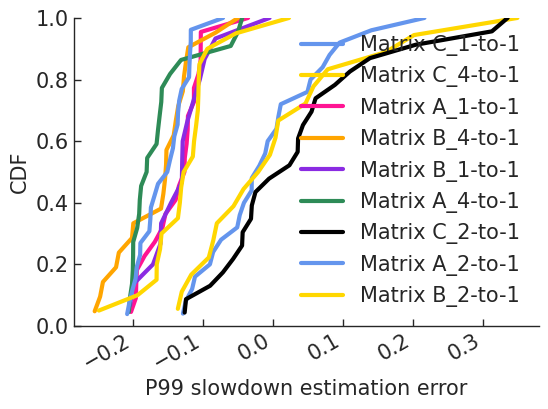

In [30]:
file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }
traffic_dict=defaultdict(list)
mix_file = '../spec/all.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
for mix_id in range(192):
    mix=mixes[mix_id]
    traffic_mat=file2matrix[mix['spatial']]
    oversub=file2oversub[mix['cluster']]
    traffic_dict[traffic_mat+'_'+oversub].append(mix_id)
    
# mlsys_dir_list=["mlsys_bt100"]
mlsys_dir_list=["mlsys"]
legend_list=['ns3','pmn-m',"mlsys_s2"]
res=[]
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./gen_{mlsys_dir}.npy'
    tmp=np.load(save_file)
    val=tmp[:,0,:].transpose() 
    res.append(val[0])
    res.append(val[2])

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_data=[np.array([error_abs[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'xxx.pdf',list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=True)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
plot_data=[np.array([error_real[0][i] for i in traffic_dict[key]]) for key in traffic_dict]
plot_cdf(plot_data,'xxx.pdf',list(traffic_dict.keys()),'P99 slowdown estimation error',legend_font=15,group_size=len(traffic_dict),loc=4,rotate_xaxis=True)

2266 2
flowid_list:  2266
df_mlsys:  (4, 100)
sldn_ns3:  5.424939122396774  sldn_pmn_m:  4.917280636953123  sldn_mlsys:  4.35895635507945
df_ns3: 2266, df_pmn_m: 2266, df_mlsys: 100


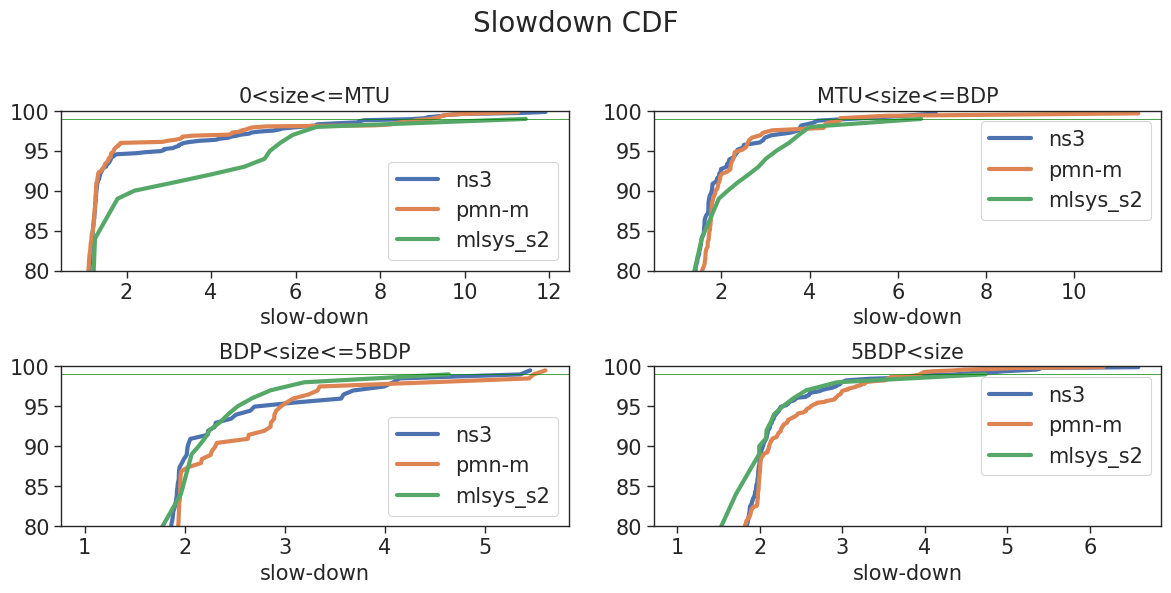

In [26]:
worst_low_id=0
mix_dir = f'../data_test/{worst_low_id}'
df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
df_mlsys = [[] for _ in range(n_size_bucket_list_output)]
path_idx=200
# mix_dir = f'/data2/lichenni/data_10m/{worst_low_id}'
mlsys_dir="mlsys"
legend_list=['ns3','pmn-m',"mlsys_s2"]
flowid_list=[]
while os.path.exists(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt'):
    with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
        data=file.readline().strip().split(",")
        n_flows_in_f=(int(data[-3]))
        n_links=len(data[0].split("|"))-1
    print(n_flows_in_f,n_links)
    with open(f'{mix_dir}/{mlsys_dir}/{path_idx}/fct_mlsys.txt', 'r') as file:
        data = np.array([float(value) for value in file.readline().strip().split()])
        assert data.shape[0] == n_size_bucket_list_output*n_percentiles
        tmp=data.reshape(n_size_bucket_list_output, n_percentiles)
        for i in range(n_size_bucket_list_output):
            df_mlsys[i].extend(recover_data(P99_PERCENTILE_LIST, tmp[i].tolist(),target_percentiles))
    with open(f'{mix_dir}/{mlsys_dir}/{path_idx}/flows.txt', 'r') as file:
        for line in file:
            data=line.strip().split()
            if len(data)==7:
                if int(data[1])==0 and int(data[2])==n_links:
                    flowid_list.append(int(data[0]))
    break
    path_idx+=1
print("flowid_list: ",len(flowid_list))
df_mlsys=np.array(df_mlsys)
print("df_mlsys: ",df_mlsys.shape)

df_ns3=df_ns3[df_ns3['flow_id'].isin(flowid_list)]
df_pmn_m=df_pmn_m[df_pmn_m['flow_id'].isin(flowid_list)]

sizes_ns3=np.array(df_ns3['size'])
sizes_pmn=np.array(df_pmn_m['size'])
bin_ns3=np.digitize(sizes_ns3, bin_size_list)
bin_pmn=np.digitize(sizes_pmn, bin_size_list)

# Count occurrences of each bin index
bin_counts = np.bincount(bin_ns3)
# Calculate the total count
total_count = np.sum(bin_counts)
# Calculate the ratio for each bucket
bucket_ratios = bin_counts / total_count
sldn_mlsys=np.sum(np.multiply(df_mlsys.T, bucket_ratios).T,axis=0)

sldn_ns3=df_ns3['slowdown']
sldn_pmn_m=df_pmn_m['slowdown']
# print(f"{worst_low_id}: path={src_dst_pair}, len=",df_ns3.shape[0],df_pmn_m.shape[0],df_ns3_path.shape[0],df_flowsim.shape[0])
sldn_ns3_p99=np.percentile(sldn_ns3,99)
sldn_pmn_m_p99=np.percentile(sldn_pmn_m,99)
sldn_mlsys_p99=np.percentile(sldn_mlsys,99)
    
print("sldn_ns3: ",sldn_ns3_p99," sldn_pmn_m: ", sldn_pmn_m_p99," sldn_mlsys: ", sldn_mlsys_p99)

# assert df_ns3.shape[0]==df_pmn_m.shape[0]==df_ns3_path.shape[0]==sldn_flowsim.shape[0]
print(f"df_ns3: {df_ns3.shape[0]}, df_pmn_m: {df_pmn_m.shape[0]}, df_mlsys: {df_mlsys.shape[1]}")
        
bin_ns3=np.digitize(sizes_ns3, bin_size_list)
bin_pmn=np.digitize(sizes_pmn, bin_size_list)
for i in range(len(bin_size_list)+1):
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn==i, sldn_pmn_m)
    tmp_sldn_mlsys=df_mlsys[i]
    
plt.figure(0,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF\n",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}",fontsize=_fontsize)
    
    tmp_sldn_ns3 = np.extract(bin_ns3==i, sldn_ns3)
    tmp_sldn_pmn_m = np.extract(bin_pmn==i, sldn_pmn_m)
    tmp_sldn_mlsys=df_mlsys[i]
    res=[tmp_sldn_ns3,tmp_sldn_pmn_m,tmp_sldn_mlsys]
    for j in range(len(legend_list)):
        tmp=res[j]
        plt.plot(np.sort(tmp), (np.arange(len(tmp))/len(tmp)*100), label=legend_list[j], linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()

In [42]:
def create_record(mix):
    
    file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
    file2dist = {
        '../../workload/distributions/facebook/webserver-all.txt': 'WebServer',
        '../../workload/distributions/facebook/hadoop-all.txt': 'Hadoop',
        '../../workload/distributions/facebook/cachefollower-all.txt': 'CacheFollower',
    }
    file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

    mix_id = mix['id']
    mix_dir = f'../data/{mix_id}'
    
    # Load info
    with open(f'{mix_dir}/pmn-m/loads.json') as f:
        loads = json.load(f)
        loads.sort(reverse=True)
    loads = pd.DataFrame(loads, columns=['load'])
    max_load = loads['load'][0]
    idx = int(len(loads) * 0.1)
    top10pct_load = loads['load'][:idx].mean()

    assert (os.path.exists(f'../data/{mix["id"]}/mlsys/elapsed.txt'))
        
    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_mlsys = []
    for path_idx in range(NR_PATHS_SAMPLED):
        with open(f'{mix_dir}/mlsys/{path_idx}/fct_mlsys.txt', 'r') as file:
            data = np.array([float(value) for line in file for value in line.split()])
            assert data.shape[0] == n_size_bucket_list_output*n_percentiles
            df_mlsys.append(data.reshape(n_size_bucket_list_output, n_percentiles))
    df_mlsys_tmp=np.array(df_mlsys)
    df_mlsys=[]
    for i in range(n_size_bucket_list_output):
        df_mlsys.append(df_mlsys_tmp[:,i,:].flatten())
    df_mlsys=pd.DataFrame(np.array(df_mlsys).flatten())
    
    
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0])
    # if not (df_ns3.shape[0]==df_pmn_m.shape[0]==df_pmn_mc.shape[0]==df_ns3_path.shape[0]==df_flowsim.shape[0]):
    #     return {
    #     'id': mix['id'],
    #     'matrix': file2matrix[mix['spatial']],
    #     'size_dist': file2dist[mix['size_dist']],
    #     'lognorm_sigma': mix['lognorm_sigma'],
    #     'max_load_spec': mix['max_load'],
    #     'max_load': max_load,
    #     'top10pct_load': top10pct_load,
    #     'oversub': file2oversub[mix['cluster']],
    #     'was__ns3__pmn_m': None,
    #     'p99__ns3__pmn_m': None,
    #     'was__ns3__pmn_mc': None,
    #     'p99__ns3__pmn_mc': None,
    #     'was__ns3__ns3_path': None,
    #     'p99__ns3__ns3_path': None,
    #     'was__ns3__flowsim': None,
    #     'p99__ns3__flowsim': None,
    # }
    
    was__ns3__pmn_m = wasserstein_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    p99__ns3__pmn_m = p99_distance(df_ns3['slowdown'], df_pmn_m['slowdown'])
    # was__ns3__mlsys = wasserstein_distance(df_ns3['slowdown'], df_mlsys)
    p99__ns3__mlsys = p99_distance(df_ns3['slowdown'], df_mlsys[0])

    print(p99__ns3__mlsys)
    record = {
        'id': mix['id'],
        'matrix': file2matrix[mix['spatial']],
        'size_dist': file2dist[mix['size_dist']],
        'lognorm_sigma': mix['lognorm_sigma'],
        'max_load_spec': mix['max_load'],
        'max_load': max_load,
        'top10pct_load': top10pct_load,
        'oversub': file2oversub[mix['cluster']],
        'was__ns3__pmn_m': was__ns3__pmn_m,
        'p99__ns3__pmn_m': p99__ns3__pmn_m,
        # 'was__ns3__mlsys': was__ns3__mlsys,
        'p99__ns3__mlsys': p99__ns3__mlsys,
    }
    return record
    
def get_records():
    mix_file = '../spec/all.mix.json'
    csv_file = 'sensitivity_path_mlsys.csv'
    if os.path.exists(csv_file):
        mixes = pd.read_csv(csv_file)
    else:
        with open(mix_file) as f:
            mixes = json.load(f) 
        mixes = pd.DataFrame(list(map(create_record, mixes)))
        mixes.to_csv('sensitivity_path_mlsys.csv', index=False)
    return mixes

records = get_records()
print(records.shape)

0: len= 9999636 10000000
-0.7922124145946442
1: len= 9999636 10000000
-0.5948691803364641
2: len= 9999636 10000000
-0.743449445171297
3: len= 9999796 10000000
0.08925669180599445
4: len= 9999824 10000000
-0.22581333573511017
5: len= 9999842 10000000
-0.1729261623550203
6: len= 9999815 10000000
-0.3883320494618301
7: len= 9999842 10000000
0.16374457336074874
8: len= 9999824 10000000
-0.2643081709328043
9: len= 9999633 10000000
-0.28444359439658595
10: len= 9999636 10000000
-0.5977021418786226
11: len= 9999636 10000000
-0.677749987372149
12: len= 9999790 10000000
-0.8036990498918662
13: len= 9999842 10000000
-0.18165667847375097
14: len= 9999636 10000000
-0.6173892665490547
15: len= 9999796 10000000
-0.24936608726971876
16: len= 9999796 10000000
-0.3139035840833533
17: len= 9999815 10000000
-0.28589494479878735
18: len= 9999796 10000000
-0.17933669567687743
19: len= 9999813 10000000
-0.7596447707779673
20: len= 9999633 10000000
-0.2785471964619161
21: len= 9999636 10000000
-0.55244967330

## Max load

### CDFs

In [34]:
def ecdfplot(df, x):
    df['pct'] = df.groupby(by=['kind'], as_index=False)[x].rank(pct=True)
    plt.figure(figsize=(4, 1.5))
    ax = sns.lineplot(data=df, x=x, y='pct', hue='kind', style='kind', ci=None)
    ax.get_legend().set_title('Max load (top 10% avg)')
    ax.get_legend().set_frame_on(False)
    sns.despine()
    plt.ylabel('CDF')
    
def percentify(x):
    return f'{int(round(x, 2) * 100)}%'


In [35]:
print(records['max_load'].min())
print(records['max_load'].max())

0.2602780435058261
0.7748544133669228


In [36]:
worst_low_id=records['p99__ns3__mlsys'].idxmin()
worst_low_p99=records['p99__ns3__mlsys'].min()
worst_high_id=records['p99__ns3__mlsys'].idxmax()
worst_high_p99=records['p99__ns3__mlsys'].max()
print("{}:{}, {}:{}".format(worst_low_id, worst_low_p99, worst_high_id, worst_high_p99))
print(records[records['id']==worst_low_id])
print(records[records['id']==worst_high_id])

TypeError: reduction operation 'argmin' not allowed for this dtype

In [8]:
_fontsize=15
n_mixes=191
MTU=1000
BDP = 15 * MTU
percentile_tag=99
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=10BDP', 3:'10BDP<size'}

res=[]
for mix_id in range(n_mixes):
    mix_dir = f'../data/{mix_id}'
    error=  0.0

    # Accuracy metrics
    df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
    df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
    df_mlsys = []
    for path_idx in range(NR_PATHS_SAMPLED):
        with open(f'{mix_dir}/mlsys/{path_idx}/fct_mlsys.txt', 'r') as file:
            data = np.array([float(value) for line in file for value in line.split()])
            assert data.shape[0] == n_size_bucket_list_output*n_percentiles
            df_mlsys.append(data.reshape(n_size_bucket_list_output, n_percentiles))
    df_mlsys_tmp=np.array(df_mlsys)
    df_mlsys=[]
    for i in range(n_size_bucket_list_output):
        df_mlsys.append(df_mlsys_tmp[:,i,:].flatten())
    df_mlsys=np.array(df_mlsys).flatten()
    
    sldn_ns3=df_ns3['slowdown']
    sldn_pmn_m=df_pmn_m['slowdown']
    sldn_mlsys=df_mlsys['slowdown']
    print(f"{mix_id}: len=",df_ns3.shape[0],df_pmn_m.shape[0],df_mlsys.shape[0])

    bin_list=[np.digitize(df_ns3['size'], [MTU, BDP, 10 * BDP]),np.digitize(df_pmn_m['size'], [MTU, BDP, 10 * BDP, 100 * BDP])]
    res_tmp=[]
    for i in range(len(labels)):
        tmp_sldn_ns3 = np.extract(bin_list[0]==i, sldn_ns3)
        tmp_sldn_pmn_m = np.extract(bin_list[1]==i, sldn_pmn_m)
        tmp_sldn_mlsys = sldn_mlsys[i]
        
        if len(tmp_sldn_ns3)>0:
            res_tmp.append([np.percentile(tmp_sldn_ns3, percentile_tag), np.percentile(tmp_sldn_pmn_m, percentile_tag), np.percentile(tmp_sldn_mlsys, percentile_tag)])
        else:
            res_tmp.append([None, None, None, None])
    res.append(res_tmp)
res=np.array(res)
print(res.shape)

0: len= 5999777 6000000 1566 1566
1: len= 5999777 6000000 1566 1566
2: len= 5999777 6000000 1562 1562
3: len= 5999894 6000000 1222 1222
4: len= 5999906 6000000 1222 1222
5: len= 5999898 6000000 1741 1741
6: len= 5999880 6000000 1741 1741
7: len= 5999898 6000000 2152 2152
8: len= 5999906 6000000 1272 1272
9: len= 5999794 6000000 1019 1019
10: len= 5999777 6000000 1566 1566
11: len= 5999777 6000000 1566 1566
12: len= 5999877 6000000 1584 1584
13: len= 5999898 6000000 1741 1741
14: len= 5999777 6000000 1566 1566
15: len= 5999894 6000000 988 988
16: len= 5999894 6000000 988 988
17: len= 5999880 6000000 957 957
18: len= 5999894 6000000 1222 1222
19: len= 5999888 6000000 1584 1584
20: len= 5999794 6000000 1019 1019
21: len= 5999777 6000000 1566 1566
22: len= 5999877 6000000 1584 1584
23: len= 5999888 6000000 1568 1568
24: len= 5999880 6000000 957 957
25: len= 5999906 6000000 988 988
26: len= 5999794 6000000 1198 1198
27: len= 5999898 6000000 1741 1741
28: len= 5999906 6000000 1272 1272
29: l

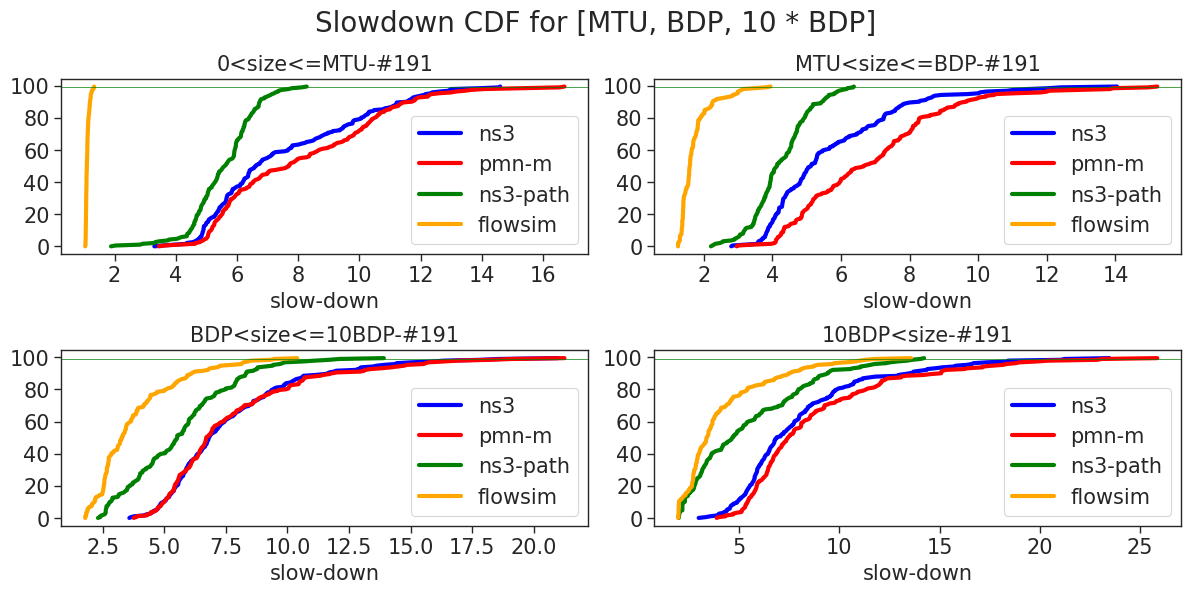

In [10]:
fig_idx=0
plt.figure(fig_idx,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for [MTU, BDP, 10 * BDP]",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3=res[:,i,0]
    tmp_sldn_pmn_m=res[:,i,1]
    tmp_sldn_mlsys=res[:,i,2]
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_ns3), (np.arange(len(tmp_sldn_ns3))/len(tmp_sldn_ns3)*100), label='ns3', color='blue', linewidth=3)
    plt.plot(np.sort(tmp_sldn_pmn_m), (np.arange(len(tmp_sldn_pmn_m))/len(tmp_sldn_pmn_m)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_mlsys), (np.arange(len(tmp_sldn_mlsys))/len(tmp_sldn_mlsys)*100), label='mlsys', color='green', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    # plt.ylim(80, 100)
    plt.xlabel('slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()
fig_idx+=1

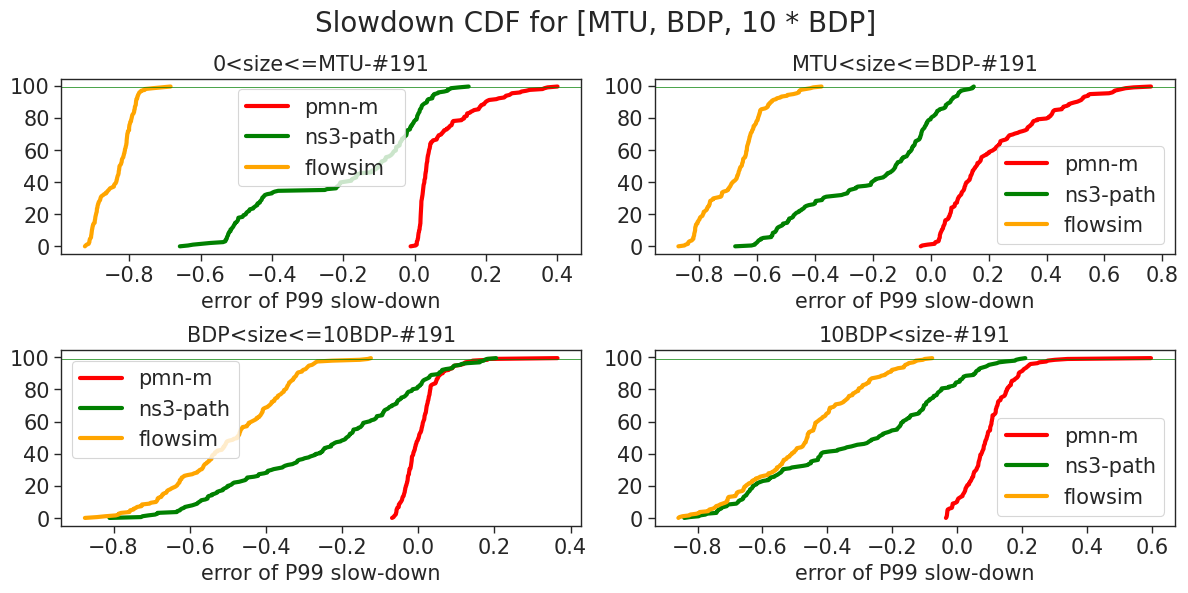

In [11]:
fig_idx=1
plt.figure(fig_idx,figsize=(12, 6))
plt.suptitle(f"Slowdown CDF for [MTU, BDP, 10 * BDP]",fontsize=_fontsize+5)
plt.rcParams['legend.fontsize'] = _fontsize
for i in range(len(labels)):
    tmp_sldn_ns3=res[:,i,0]
    tmp_sldn_pmn_m=res[:,i,1]
    tmp_sldn_mlsys=res[:,i,2]
    tmp_sldn_pmn_m_error=(tmp_sldn_pmn_m-tmp_sldn_ns3)/tmp_sldn_ns3
    tmp_sldn_mlsys_error=(tmp_sldn_mlsys-tmp_sldn_ns3)/tmp_sldn_ns3
    plt.subplot(2, 2, i + 1)
    plt.title(f"{labels[i]}-#{len(tmp_sldn_ns3)}",fontsize=_fontsize)
    plt.plot(np.sort(tmp_sldn_pmn_m_error), (np.arange(len(tmp_sldn_pmn_m_error))/len(tmp_sldn_pmn_m_error)*100), label='pmn-m', color='red', linewidth=3)
    plt.plot(np.sort(tmp_sldn_mlsys_error), (np.arange(len(tmp_sldn_mlsys_error))/len(tmp_sldn_mlsys_error)*100), label='ns3-path', color='green', linewidth=3)
    plt.axhline(99, color='green', linewidth=0.5)
    # plt.xscale('log')
    # plt.ylim(80, 100)
    plt.xlabel('error of P99 slow-down', fontsize=_fontsize)
    plt.yticks(fontsize=_fontsize)
    plt.xticks(fontsize=_fontsize)
    plt.legend()
plt.tight_layout()
fig_idx+=1

In [46]:
records = records.sort_values(by='max_load')
n = round(len(records) / 3)
records_l = records.iloc[0:n].copy()
records_m = records.iloc[n:n+n].copy()
records_h = records.iloc[n+n:].copy()

# records_l = records[records['max_load'] <= 0.5].copy()
# records_m = records[records['max_load'] <= 0.65].copy()
# records_h = records[records['max_load'] <= 1.0].copy()
max_load = records['max_load'].max()

max_load_l_min = records_l['max_load'].min()
max_load_m_min = records_m['max_load'].min()
max_load_h_min = records_h['max_load'].min()

max_load_l_max = records_l['max_load'].max()
max_load_m_max = records_m['max_load'].max()
max_load_h_max = records_h['max_load'].max()

top10pct_load_l_min = records_l['top10pct_load'].min()
top10pct_load_m_min = records_m['top10pct_load'].min()
top10pct_load_h_min = records_h['top10pct_load'].min()

top10pct_load_l_max = records_l['top10pct_load'].max()
top10pct_load_m_max = records_m['top10pct_load'].max()
top10pct_load_h_max = records_h['top10pct_load'].max()

records_l.loc[:, 'kind'] = 'low'
records_m.loc[:, 'kind'] = 'medium'
records_h.loc[:, 'kind'] = 'high'
records.loc[:, 'kind'] = 'all'
records_lmh = pd.concat([records_l, records_h, records_m, records], ignore_index=True)
x_lim_range=(-1.0, 1.0)

In [44]:
# records_lmh['p99__ns3__ns3_path'] = records_lmh['p99__ns3__ns3_path'].abs()
records_lmh['p99__ns3__mlsys'] = records_lmh['p99__ns3__mlsys'].abs()
records_lmh['p99__ns3__pmn_m'] = records_lmh['p99__ns3__pmn_m'].abs()
x_lim_range=(0, 1.0)

/tmp/ipykernel_4103997/1927044329.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_4103997/1927044329.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], ci = None, ax=axs)
/tmp/ipykernel_4103997/1927044329.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_4103997/1927044329

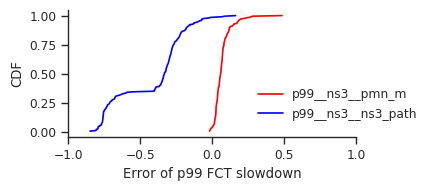

In [47]:
# column_list=['p99__ns3__ns3_path','p99__ns3__flowsim','p99__ns3__pmn_m','p99__ns3__pmn_mc']
# column_list=['p99__ns3__pmn_m','p99__ns3__flowsim','p99__ns3__ns3_path']
column_list=['p99__ns3__pmn_m','p99__ns3__mlsys']
color_list=["red","blue", "orange","black"]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
for i,each in enumerate(column_list):
    data=records_lmh.loc[records_lmh['kind'] == 'all']
    data['pct'] = data[each].rank(pct=True)
    ax=sns.lineplot(data = data, x = each, y = 'pct', color = color_list[i], ci = None, ax=axs)
    
    # handles = ax.get_legend().get_lines()
    # ax.get_legend().remove()
title=''
# labels=[
#     f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
#     f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
#     f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
#     'all scenarios'
# ]
# labels=column_list
labels=['p99__ns3__pmn_m','p99__ns3__ns3_path','p99__ns3__flowsim']
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(labels=labels, title=title, loc='lower right', frameon=False, ncol=1, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.xlim(x_lim_range)
plt.savefig('figs/error-dist-all-0.pdf', bbox_inches='tight')

/tmp/ipykernel_1507609/2149743350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_1507609/2149743350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct'] = data[each].rank(pct=True)
/tmp/ipykernel_1507609/2149743350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

p99__ns3__ns3_path:  0.1356786771157325 0.865316163897542
p99__ns3__ns3_path:  0.1356786771157325 0.865316163897542
p99__ns3__pmn_m:  0.0042586963499002 0.4953989292694878
p99__ns3__pmn_m:  0.0042586963499002 0.4953989292694878


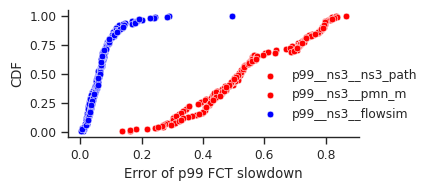

In [12]:
records_lmh_sorted=records_lmh.sort_values(by='lognorm_sigma')
# column_list=['p99__ns3__ns3_path','p99__ns3__flowsim','p99__ns3__pmn_m','p99__ns3__pmn_mc']
column_list=['p99__ns3__ns3_path','p99__ns3__pmn_m']
column_list_2=[1,2]
color_list=["red","blue", "orange","black"]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)
for i,each in enumerate(column_list):
    for i2,each2 in enumerate(column_list_2):
        data=records_lmh_sorted.loc[(records_lmh_sorted['kind'] == 'all') & (records_lmh_sorted['lognorm_sigma'] == column_list_2[i2])]
        data['pct'] = data[each].rank(pct=True)
        ax=sns.scatterplot(data = data, x = each, y = 'pct', color = color_list[i], ax=axs)
        print(f"{each}: ",records_lmh_sorted[each].min(),records_lmh_sorted[each].max())
        # handles = ax.get_legend().get_lines()
        # ax.get_legend().remove()
title=''
# labels=[
#     f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
#     f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
#     f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
#     'all scenarios'
# ]
# labels=column_list
labels=['p99__ns3__ns3_path','p99__ns3__pmn_m','p99__ns3__flowsim']
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(labels=labels, title=title, loc='lower right', frameon=False, ncol=1, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-all-0.pdf', bbox_inches='tight')

In [13]:
target_method='p99__ns3__ns3_path'
# ['p99__ns3__ns3_path','p99__ns3__flowsim','p99__ns3__pmn_m','p99__ns3__pmn_m_path']

/tmp/ipykernel_1507609/549758537.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(data=records_lmh, x=target_method, y='pct', hue='kind', style='kind', ci=None)


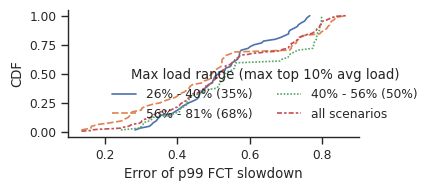

In [14]:
# records_lmh=abs(records_lmh)
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3.7, 2.0), sharex=True)

records_lmh['pct'] = records_lmh.groupby(by=['kind'], as_index=False)[target_method].rank(pct=True)
ax = sns.lineplot(data=records_lmh, x=target_method, y='pct', hue='kind', style='kind', ci=None)

handles = ax.get_legend().get_lines()
ax.get_legend().remove()
title='Max load range (max top 10% avg load)'
labels=[
    f'{percentify(max_load_l_min)} - {percentify(max_load_l_max)} ({percentify(top10pct_load_l_max)})',
    f'{percentify(max_load_h_min)} - {percentify(max_load_h_max)} ({percentify(top10pct_load_h_max)})',
    f'{percentify(max_load_m_min)} - {percentify(max_load_m_max)} ({percentify(top10pct_load_m_max)})',
    'all scenarios'
]
# XXX: This is a dirty hack. Look carefully at the labels!
fig.legend(handles=handles, labels=labels, title=title, loc='lower right', frameon=False, ncol=2, bbox_to_anchor=(1.15, 0.32))
sns.despine()
fig.tight_layout()
plt.xlabel('Error of p99 FCT slowdown')
plt.ylabel('CDF')
plt.savefig('figs/error-dist-0.pdf', bbox_inches='tight')

###  Misc

In [15]:
records[target_method].max()
records['max_load'].quantile(0.6)
records_h[target_method].mean()
records[(records['oversub'] == '2-to-1') & (records['size_dist'] == 'WebServer') & (records['matrix'] == 'Matrix B')].sort_values(by=target_method, ascending=False).iloc[:10]

,id,matrix,size_dist,lognorm_sigma,max_load_spec,max_load,top10pct_load,oversub,was__ns3__pmn_m,p99__ns3__pmn_m,was__ns3__ns3_path,p99__ns3__ns3_path,was__ns3__flowsim,p99__ns3__flowsim,kind
63,63,Matrix B,WebServer,2.0,0.731133,0.808883,0.610737,2-to-1,0.489892,0.192121,1.040115,-0.500934,1.040115,-0.500934,all
74,74,Matrix B,WebServer,1.0,0.590949,0.654366,0.494073,2-to-1,0.219546,0.105964,0.647344,-0.530546,0.647344,-0.530546,all
183,183,Matrix B,WebServer,2.0,0.466966,0.516671,0.390106,2-to-1,0.135337,0.060288,0.423293,-0.531616,0.423293,-0.531616,all
175,175,Matrix B,WebServer,1.0,0.491736,0.544714,0.411281,2-to-1,0.135671,0.057512,0.442162,-0.533510,0.442162,-0.533510,all
146,146,Matrix B,WebServer,2.0,0.487395,0.539387,0.407257,2-to-1,0.149169,0.062126,0.459714,-0.537046,0.459714,-0.537046,all
68,68,Matrix B,WebServer,2.0,0.255738,0.282964,0.213648,2-to-1,0.048989,0.054818,0.149684,-0.546935,0.149684,-0.546935,all
29,29,Matrix B,WebServer,1.0,0.518351,0.574143,0.433500,2-to-1,0.155137,0.064026,0.491366,-0.547129,0.491366,-0.547129,all
17,17,Matrix B,WebServer,2.0,0.259027,0.286563,0.216365,2-to-1,0.049879,0.055913,0.152724,-0.550095,0.152724,-0.550095,all
168,168,Matrix B,WebServer,2.0,0.351868,0.389325,0.293955,2-to-1,0.078281,0.066477,0.257998,-0.572079,0.257998,-0.572079,all
24,24,Matrix B,WebServer,2.0,0.349409,0.386599,0.291896,2-to-1,0.077280,0.066895,0.255549,-0.573005,0.255549,-0.573005,all


### Less than 10% error?

In [16]:
pct_lt_10_l = len(records_l[records_l[target_method] <= 0.1]) / len(records_l)
pct_lt_10_m = len(records_m[records_m[target_method] <= 0.1]) / len(records_m)
pct_lt_10_h = len(records_h[records_h[target_method] <= 0.1]) / len(records_h)
pct_lt_10 = len(records[records[target_method] <= 0.1]) / len(records)
print(f'low: {percentify(pct_lt_10_l)}')
print(f'med: {percentify(pct_lt_10_m)}')
print(f'high: {percentify(pct_lt_10_h)}')
print(f'all: {percentify(pct_lt_10)}')

records_lm = pd.concat([records_l, records_m])
pct_lt_10_lm = len(records_lm[records_lm[target_method] <= 0.1]) / len(records_lm)
print(f'low-to-med: {int(round(pct_lt_10_lm, 2) * 100)}%')


low: 100%
med: 100%
high: 100%
all: 100%
low-to-med: 100%


### Fails to bound?

In [17]:
lt_0 = records[records[target_method] < 0.0]
pct_lt_0 = len(lt_0) / len(records)
print(f'{int(round(pct_lt_0, 2) * 100)}%')
print(lt_0[target_method].min())

100%
-0.865316163897542


## Everything else (fix moderate load)

In [18]:
def violins(df):
    xs_labels_orders_rot = [
        ('matrix', 'Matrix', ['Matrix A', 'Matrix B', 'Matrix C'], 0),
        ('oversub', 'Oversubscription', ['1-to-1', '2-to-1', '4-to-1'], 0),
        ('size_dist', 'Flow size distribution', ['CacheFollower', 'WebServer', 'Hadoop'], 0),
        ('lognorm_sigma', 'Burstiness (log-normal σ)', [1.0, 2.0], 0),
    ]
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(5.5, 3.4), sharey=True)
    for i, (x, label, order, rot) in enumerate(xs_labels_orders_rot):
        j, k = i % 2, int(i / 2)
        ax = sns.violinplot(data=df, x=x, y=target_method, order=order, ax=axs[j, k])
        ax.set_xlabel(label)
        for tick in ax.get_xticklabels():
            tick.set_rotation(rot)
        ax.set_ylabel('')
    plt.ylim(-1, 1)
    sns.despine()
    fig.supylabel('Error of p99 FCT slowdown')
    fig.tight_layout()

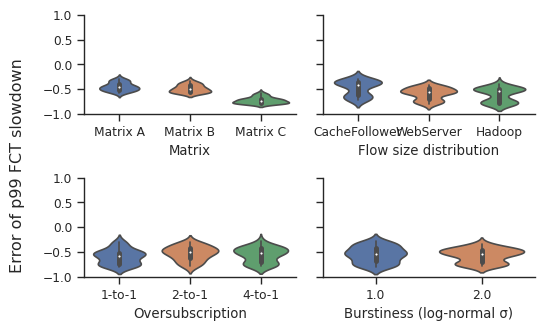

In [19]:
df_violin_lo = records[records['max_load'] <= records['max_load'].quantile(0.5)]
violins(df_violin_lo)
plt.savefig('figs/error-dist-1.pdf', bbox_inches='tight')

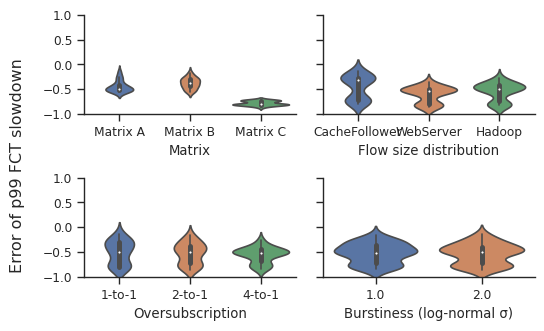

In [20]:
df_violin_hi = records[records['max_load'] > records['max_load'].quantile(0.5)]
violins(df_violin_hi)
plt.savefig('figs/error-dist-2.pdf', bbox_inches='tight')

## Scratch

In [21]:
alt.Chart(records).mark_point().encode(
    x=alt.X('max_load:Q'),
    y=alt.Y('p99__ns3__pmn_m:Q'),
    color=alt.Color('matrix:N'),
    shape=alt.Shape('size_dist:N'),
    size=alt.Size('lognorm_sigma:N'),
    opacity=alt.Opacity('oversub:N'),
    tooltip='id:N'
)

alt.Chart(...)